*Lung Opacity Vs. Normal: 
Normal: 0, 
Lung Opacity: 1*

---



In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct  4 21:22:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
!unzip /content/drive/MyDrive/newmonya/rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

In [6]:
pip install tree

     |████████████████████████████████| 66 kB 3.0 MB/s 
  Created wheel for tree: filename=Tree-0.2.4-py3-none-any.whl size=7874 sha256=cff3366822fdae3cbfee7d5df83723e91bf85c9bf9fbbaeeda5c1d789409ba3c
  Stored in directory: /root/.cache/pip/wheels/64/46/53/3a413f321c09b0df8d4a26edd5fc3501c6c1b238497d166638
Successfully built tree


In [7]:
try:
  # Use the Colab's preinstalled TensorFlow 2.x
  %tensorflow_version 2.x 
except:
  pass

In [8]:
pip install -q tensorflow-io

     |████████████████████████████████| 22.7 MB 304 kB/s 
     |████████████████████████████████| 2.1 MB 31.9 MB/s 


In [9]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

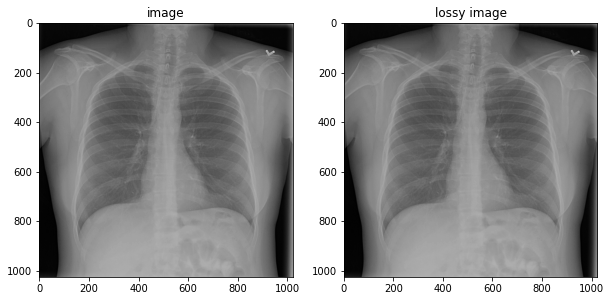

In [10]:
import tensorflow_io as tfio

image_bytes = tf.io.read_file('/content/stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');

In [11]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [12]:
import numpy as np
import pandas as pd
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

In [13]:
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array


In [27]:
# read data
# Assuming it has two cols:
# image_path: path to each image with its extension
# target: labels (here it is 0s and 1s) -> binary classification
df = pd.read_csv("/content/drive/MyDrive/newmonya/newmonya.csv", dtype=str)

# split for testing
train_df, test_df = train_test_split(df, test_size=0.2)

from skimage import exposure
def clahe(image):
    image = exposure.equalize_adapthist(image/np.max(image))
   
    return image

In [28]:
train_augmentation_parameters = dict(
    rescale=clahe,
    rotation_range=10,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    rescale=clahe,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    rescale=clahe
)

In [16]:
BATCH_SIZE = 32
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 10
SEED = 1337

In [17]:
train_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training', 
    'shuffle': True
}

valid_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation',
    'shuffle': True
}

test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}

In [29]:
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)


train_generator = DCMDataFrameIterator(dataframe=train_df,
                             x_col='img',
                             y_col='class',
                             image_data_generator=train_augmenter,
                             **train_consts)

valid_generator = DCMDataFrameIterator(dataframe=train_df,
                             x_col='img',
                             y_col='class',
                             image_data_generator=valid_augmenter,
                             **valid_consts)

Found 11780 validated image filenames belonging to 2 classes.
Found 2944 validated image filenames belonging to 2 classes.


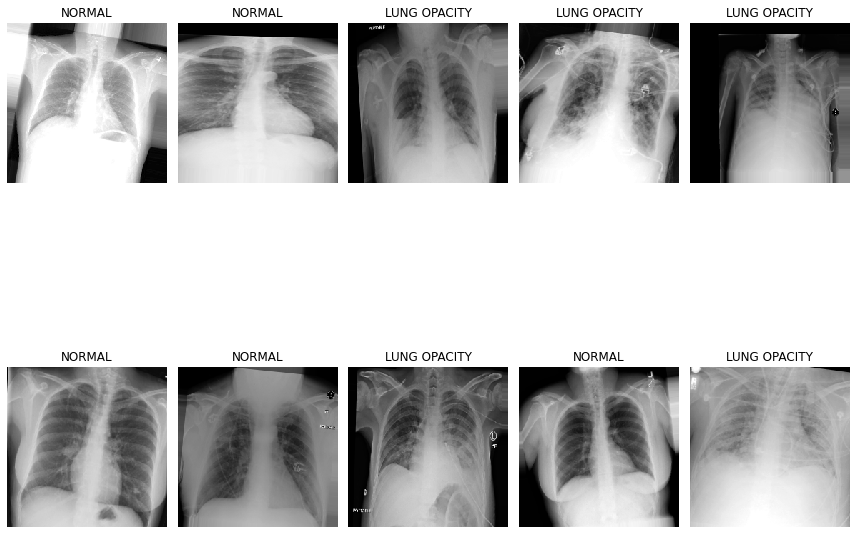

In [30]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'LUNG OPACITY'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

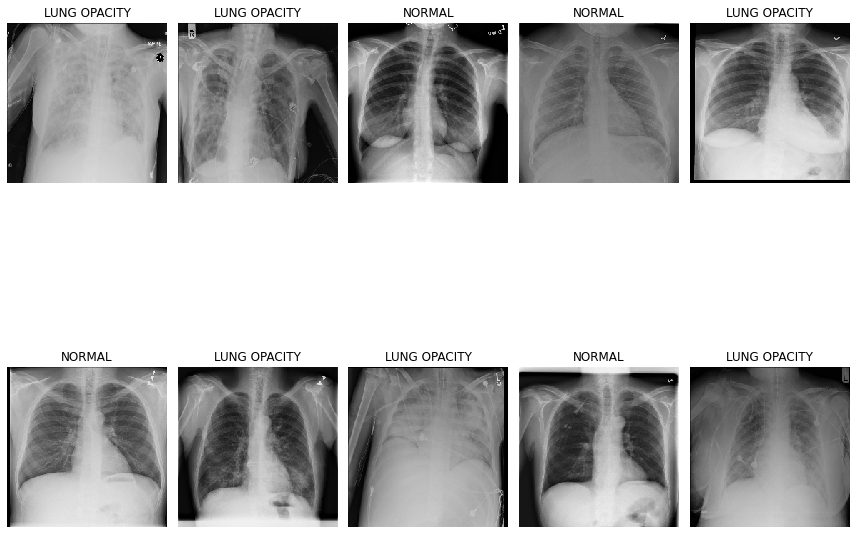

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in valid_generator:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'LUNG OPACITY'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
train_generator.class_indices

{'0': 0, '1': 1}

In [32]:
import tempfile
import os
def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.00001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
def build_model():
  base = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights='imagenet')
  base = add_regularization(base)
  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation = 'sigmoid'))
    
  model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = 'binary_crossentropy',
       metrics = ['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
  return model


In [34]:
model = build_model()
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [24]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/newmonya/model3.ckpt', 
    verbose=0, 
    save_weights_only=True,
    save_freq=5*32)

In [35]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    verbose = 2, 
    callbacks = cp_callback
)

Epoch 1/25
369/369 - 261s - loss: 0.3689 - accuracy: 0.8663 - precision: 0.8764 - recall: 0.8639 - val_loss: 0.5450 - val_accuracy: 0.7303 - val_precision: 0.6650 - val_recall: 0.9917
Epoch 2/25
369/369 - 245s - loss: 0.2521 - accuracy: 0.9269 - precision: 0.9363 - recall: 0.9217 - val_loss: 0.2059 - val_accuracy: 0.9385 - val_precision: 0.9244 - val_recall: 0.9629
Epoch 3/25
369/369 - 248s - loss: 0.2234 - accuracy: 0.9369 - precision: 0.9467 - recall: 0.9307 - val_loss: 0.1668 - val_accuracy: 0.9562 - val_precision: 0.9686 - val_recall: 0.9482
Epoch 4/25
369/369 - 255s - loss: 0.2030 - accuracy: 0.9438 - precision: 0.9543 - recall: 0.9365 - val_loss: 0.1694 - val_accuracy: 0.9582 - val_precision: 0.9574 - val_recall: 0.9642
Epoch 5/25
369/369 - 258s - loss: 0.1884 - accuracy: 0.9525 - precision: 0.9637 - recall: 0.9440 - val_loss: 0.1602 - val_accuracy: 0.9592 - val_precision: 0.9775 - val_recall: 0.9450
Epoch 6/25
369/369 - 261s - loss: 0.1780 - accuracy: 0.9549 - precision: 0.9653 

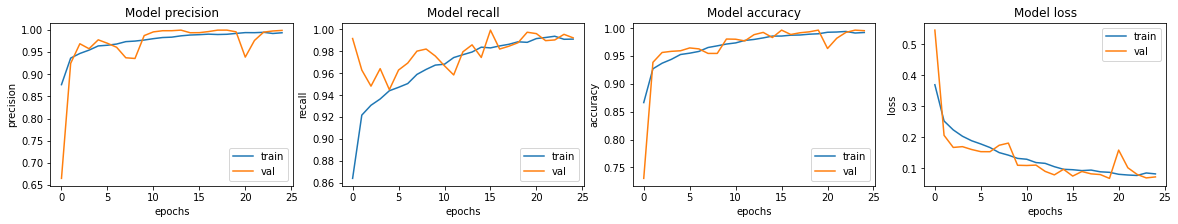

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
test_augmenter = ImageDataGenerator(**test_augmentation_parameters)
test_generator = DCMDataFrameIterator(dataframe=test_df,
                             x_col='img',
                             y_col='class',
                             image_data_generator=test_augmenter,
                             **test_consts)


Found 3682 validated image filenames belonging to 2 classes.


In [38]:
acc, loss, prec, rec = model.evaluate(test_generator, verbose = 1)

3682/3682 [==============================] - 60s 16ms/step - loss: 0.2936 - accuracy: 0.9571 - precision: 0.9773 - recall: 0.9379


Evaluating the test predictions: 

In [39]:
predictions = model.predict(test_generator, steps = len(test_generator))

In [40]:
rounded_predictions = np.round(predictions)

In [41]:
test_labels = test_generator.classes

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
conf = confusion_matrix(test_labels, rounded_predictions)

In [44]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
test_generator.class_indices

{'0': 0, '1': 1}

Confusion matrix, without normalization
[[1756   41]
 [ 117 1768]]


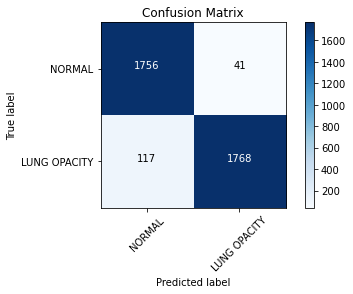

In [46]:
cm_plot_labels = ['NORMAL', 'LUNG OPACITY']
plot_confusion_matrix(cm=conf, classes=cm_plot_labels, title='Confusion Matrix')

In [47]:
model.save('/content/drive/MyDrive/project/model4.h5')
model.save_weights('/content/drive/MyDrive/project/model4_weights.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [48]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve ( test_labels , rounded_predictions)

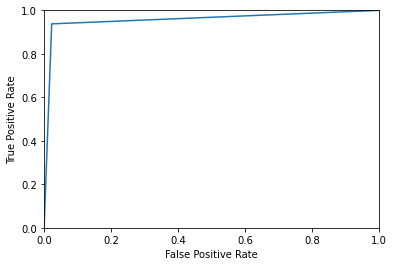

In [49]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

In [50]:
auc_score=roc_auc_score(test_labels,rounded_predictions) 
auc_score

0.9575576151823921